Assuming you have pytorch and sklearn installed already.

Additional library:

In [ ]:
!pip install transformers

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from transformers import RobertaForTokenClassification, RobertaTokenizer

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# visualisation and plotting
import tqdm
tqdmn = tqdm.notebook.tqdm
import matplotlib.pyplot as plt

Download and initialise the pre-trained model, tokenizer from huggingface

The model I'm using is technically ROBERTA but with additional pre-training on scientific papers. In theory this model should perform better than a regular pre-trained model (e.g. ROBERTA, BERT) in biomedical related tasks.

model's details https://huggingface.co/allenai/biomed_roberta_base

In [3]:
model_id="allenai/biomed_roberta_base"
tokenizer = RobertaTokenizer.from_pretrained(model_id)
model = RobertaForTokenClassification.from_pretrained(model_id, num_labels=3)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/185 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/430 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/biomed_roberta_base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on

**Preparing the data**


In [4]:
# Read from the tsv file and return a list of dict
def load_sentences_from_file(path, label2id):
    sentences = []
    sentence = {
        'tokens': [],
        'ner_tags': []
    }
    for line in open(path, 'r', encoding='utf-8'):
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence['tokens']) > 0:
                sentences.append(sentence)
            sentence = {
                'tokens': [],
                'ner_tags': []
            }
        else:
            splits = line.split()
            if len(splits) == 2:
                sentence['tokens'].append(splits[0])
                sentence['ner_tags'].append(label2id[splits[1]])
    if len(sentence['tokens']) > 0:
        sentences.append(sentence)
    return sentences

# encode word tokens into {input_ids: [], attention_mask: [], labels: []} using the default tokenizer of ROBERTA
# but we don't actually tokenize the str here as it's already been tokenized
def word_encodings(sentence):
    encodings = tokenizer(sentence['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    # extend labels to the max_len of the model input
    labels = torch.tensor(sentence['ner_tags'] + [0] * (tokenizer.model_max_length - len(sentence['ner_tags'])))
    return { **encodings, 'labels': labels }

def convert_to_tensor(data):
    for entry in data:
        for key, value in entry.items():
            entry[key] = torch.tensor(value)
    return data

Hard-coded lables dicts for the model configuration and later in the pipeline

In [5]:
id2label = {
    0: 'O',
    1: 'B',
    2: 'I'
}
label2id = { value: key for key, value in id2label.items() }
model.config.id2label = id2label
model.config.label2id = label2id

dataset = {}
dataset['train'] = convert_to_tensor(list(map(word_encodings, load_sentences_from_file('./NERdata/train.tsv',label2id))))
dataset['test'] = convert_to_tensor(list(map(word_encodings, load_sentences_from_file('./NERdata/test.tsv',label2id))))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


**Training parameters**

Adam optimizer is always my first choice when it comes to gradient descent

3 epochs are plenty for NER

batch_size set to 6 because any more than that would exceed the available GPU memory in Colab. Ideally, the larger batch size is usually better.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train().to(device)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)
epochs = 3
batch_size = 6
log_freq = 10
training_loss = []
train_data = torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size)

**Training**

In [9]:
# start training
for epoch in tqdmn(range(epochs)):
    cached_loss = 0
    for batch_index, batch_data in enumerate(tqdmn(train_data)):
        # load batch data in memory
        batch_data = { key: value.to(device) for key, value in batch_data.items() }
        # compute logits and loss
        outputs = model(**batch_data)
        loss = outputs.loss
        # backpropagation
        loss.backward()
        # update model
        optimizer.step()
        # reset gradients
        optimizer.zero_grad()
        # cache loss for plotting
        cached_loss += loss.item()
        if batch_index % log_freq == 0 and batch_index > 0:
            # cache losses in final list
            training_loss.append(cached_loss / (log_freq * batch_size))
            cached_loss = 0
    # update model at the end of each epoch
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/904 [00:00<?, ?it/s]

  0%|          | 0/904 [00:00<?, ?it/s]

  0%|          | 0/904 [00:00<?, ?it/s]

Training loss reached minimum after roughly two epochs

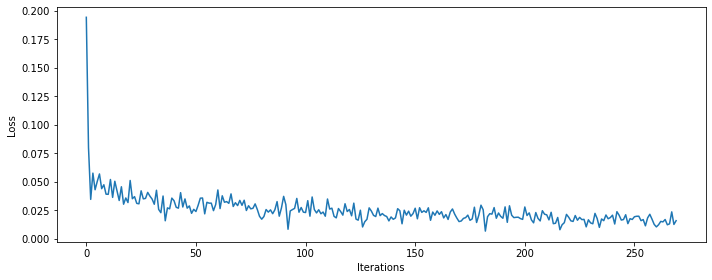

In [10]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(training_loss)
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations')
fig.tight_layout()
plt.show()

**Testing**

In [11]:
model = model.eval()
test_data = torch.utils.data.DataLoader(dataset['test'], batch_size=batch_size)

In [12]:
for batch_index, batch_data in enumerate(tqdmn(test_data)):
    with torch.no_grad():
        batch_data = { key: value.to(device) for key, value in batch_data.items() }
        outputs = model(**batch_data)
    
    seq_len = batch_data['attention_mask'].sum(dim=1)
    for index, length in enumerate(seq_len):
        groundtrue = batch_data['labels'][index][:length]
        preds = torch.argmax(outputs[1], dim=2)[index][:length]

  0%|          | 0/157 [00:00<?, ?it/s]

The result is not SOTA but I think it's pretty good for such a simple data preparation and optimisation.

In [13]:
print("Accuracy: {0}".format(accuracy_score(groundtrue.cpu(), preds.cpu())))
print("F1: {0}".format(f1_score(groundtrue.cpu(),preds.cpu(),average='weighted')))
print("Precision: {0}".format(precision_score(groundtrue.cpu(),preds.cpu(),average='weighted',zero_division=1)))
print("Recall: {0}".format(recall_score(groundtrue.cpu(),preds.cpu(),average='weighted')))

Accuracy: 0.8846153846153846
F1: 0.8727588201272412
Precision: 0.9002403846153846
Recall: 0.8846153846153846


In [14]:
model.save_pretrained('./saved_model')